In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [2]:
ranked_shops = pd.read_csv('../data/ranked_shops.csv')


In [3]:
ranked_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      463 non-null    int64  
 1   Shop_Name                       463 non-null    object 
 2   Address                         463 non-null    object 
 3   Latitude                        463 non-null    float64
 4   Longitude                       463 non-null    float64
 5   Rating                          463 non-null    float64
 6   Reviews_Count                   463 non-null    int64  
 7   Place_ID                        463 non-null    object 
 8   Price_Level                     463 non-null    float64
 9   types                           463 non-null    object 
 10  Borough                         463 non-null    object 
 11  Property_Value_2017             463 non-null    float64
 12  Earnings_2021                   463 

Prepare the data:

In [4]:
# Define the feature columns
feature_columns = [
    'Rating', 'Reviews_Count', 'Price_Level', 'Property_Value_2017',
    'Earnings_2021', 'composite_score'
]


# K-means

In [5]:
# Extract features from the dataset
X = ranked_shops[feature_columns]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)


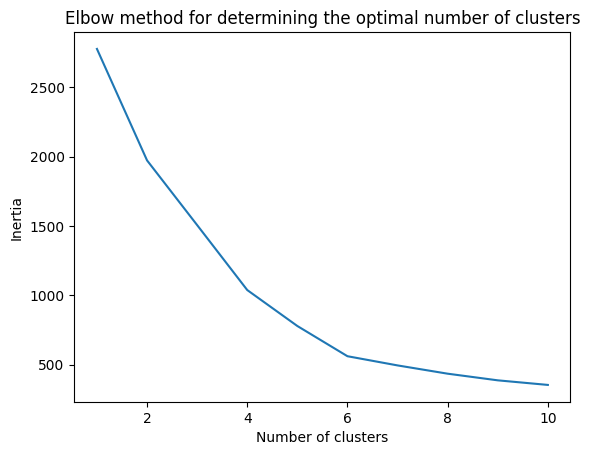

In [6]:
# Plot the inertia values
import matplotlib.pyplot as plt

plt.plot(range(1, 11), inertia_values)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for determining the optimal number of clusters')
plt.show()


In [10]:
# Choose the optimal number of clusters based on the elbow plot
optimal_clusters = 6

# Train the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign the clusters to the dataset
ranked_shops['cluster'] = kmeans.labels_

# EDA to explore the output

In [11]:
print(ranked_shops.dtypes)


Unnamed: 0                          int64
Shop_Name                          object
Address                            object
Latitude                          float64
Longitude                         float64
Rating                            float64
Reviews_Count                       int64
Place_ID                           object
Price_Level                       float64
types                              object
Borough                            object
Property_Value_2017               float64
Earnings_2021                     float64
IMD_Rank                          float64
Income_Rank                       float64
composite_score                   float64
Rating_normalized                 float64
Property_Value_2017_normalized    float64
Earnings_2021_normalized          float64
Reviews_Count_normalized          float64
Price_Level_normalized            float64
Rank                              float64
cluster                             int32
dtype: object


In [12]:
# Group the data by cluster labels and calculate the mean for each group
#cluster_means = ranked_shops.groupby('cluster').mean()

# Display the cluster means
# print(cluster_means)


In [13]:
# Summary statistics for each cluster
cluster_summary = ranked_shops.groupby('cluster').describe()
display(cluster_summary)


Unnamed: 0                                                        
             count        mean        std    min     25%    50%     75%   
cluster                                                                   
0             11.0  106.090909  68.456489    1.0   62.50  103.0  138.00  \
1            188.0  187.601064  68.614753   60.0  132.75  182.5  230.25   
2             75.0   42.400000  24.785022    3.0   21.50   41.0   62.50   
3              4.0   33.500000  38.596200    0.0    1.50   28.5   60.50   
4            143.0  342.265734  53.415453  229.0  304.50  344.0  388.50   
5             42.0  434.738095  24.923355  362.0  430.25  441.5  451.75   

               Latitude             ... Price_Level_normalized             
           max    count       mean  ...                    75%       max   
cluster                             ...                                    
0        242.0     11.0  51.504815  ...               0.033784  0.033784  \
1        383.0    188.0  51.497996  ...               0.033784  0.033784   
2        101.0     75.0  51.508167  ...               0.033784  0.033784   
3         77.0      4.0  51.508193  ...               0.625000  1.000000   
4        435.0    143.0  51.513102  ...               0.033784  0.033784   
5        462.0     42.0  51.506153  ...               0.033784  0.033784   

          Rank                                                              
         count        mean        std    min     25%    50%     75%    max  
cluster                                                                     
0         11.0  107.090909  68.456489    2.0   63.50  104.0  139.00  243.0  
1        188.0  188.547872  68.622371   61.0  133.75  183.5  231.25  384.0  
2         75.0   43.360000  24.809893    4.0   22.00   42.0   63.50  102.0  
3          4.0   34.500000  38.596200    1.0    2.50   29.5   61.50   78.0  
4        143.0  343.237762  53.454727  230.0  305.50  345.0  389.50  436.0  
5         42.0  434.190476  25.119459  363.0  429.75  441.0  447.00  463.0  

[6 rows x 136 columns]

## Random forest model:

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the data
X_rf = ranked_shops.drop(['Unnamed: 0', 'Shop_Name', 'Address', 'Place_ID', 'types', 'Borough', 'cluster'], axis=1)
y_rf = ranked_shops['cluster']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importances
feature_importances = pd.DataFrame({'feature': X_rf.columns, 'importance': rf.feature_importances_})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
display(feature_importances)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.94      1.00      0.97        50
           2       0.97      1.00      0.98        32
           3       0.00      0.00      0.00         3
           4       1.00      0.97      0.99        34
           5       1.00      1.00      1.00        17

    accuracy                           0.97       139
   macro avg       0.82      0.83      0.82       139
weighted avg       0.95      0.97      0.96       139

Accuracy: 0.9712230215827338


/Users/andrii/Documents/londons_fashionable_finds/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrii/Documents/londons_fashionable_finds/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrii/Documents/londons_fashionable_finds/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

,feature,importance
6,Earnings_2021,0.192897
12,Earnings_2021_normalized,0.178654
9,composite_score,0.151252
15,Rank,0.120787
11,Property_Value_2017_normalized,0.070814
5,Property_Value_2017,0.057579
13,Reviews_Count_normalized,0.054715
3,Reviews_Count,0.048566
2,Rating,0.046509
10,Rating_normalized,0.044270


According to the table, the top 5 most important features are:

- composite_score (0.143616)
- Earnings_2021_normalized (0.122579)
- Rank (0.114501)
- Property_Value_2017 (0.114191)
- Earnings_2021 (0.096823)

These features contribute the most to the model's ability to correctly predict the cluster labels.

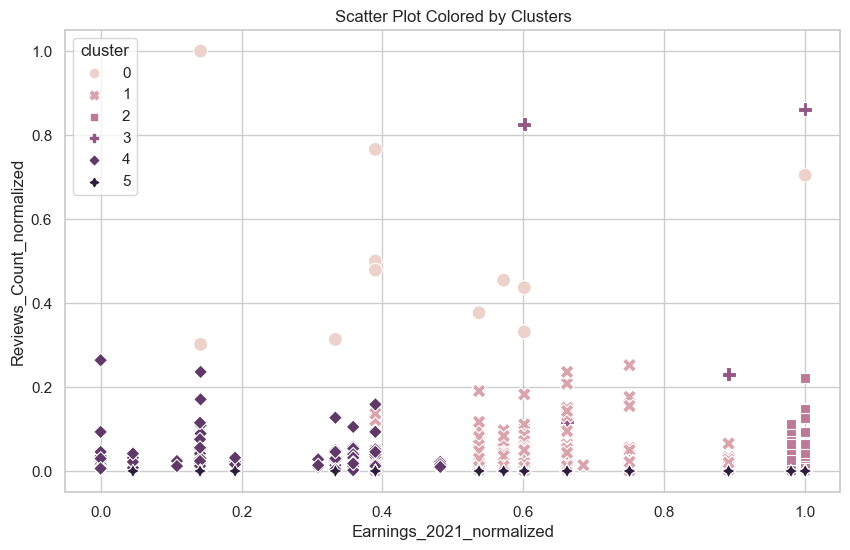

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style and color palette for the plot
sns.set(style="whitegrid")
sns.set_palette("husl")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ranked_shops, x="Earnings_2021_normalized", y="Reviews_Count_normalized", hue="cluster", style="cluster", s=100)

# Set the title and labels for the axes
plt.title("Scatter Plot Colored by Clusters")
plt.xlabel("Earnings_2021_normalized")
plt.ylabel("Reviews_Count_normalized")

# Display the plot
plt.show()
